In [132]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score,KFold
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

In [133]:
df = df_ = pd.read_csv(filepath_or_buffer="C:\\Lib\\fifa_players.csv")
df = df_.copy()

In [134]:
from sklearn.preprocessing import LabelEncoder
df = df.drop(columns=['full_name','name','birth_date','nationality'])

categorical_to_nums = {'preferred_foot'  :   {'Left'  : 0, 'Right' : 1,},
                       'body_type'  :   {'Lean'  : 0, 'Normal' : 1, 'Stocky' : 2}} 
for column, mapping in categorical_to_nums.items():
    temp_series = df[column].copy()
    null_mask = temp_series.isnull()
    temp_series.loc[~null_mask] = temp_series.loc[~null_mask].map(mapping) 
    df[column] = temp_series.fillna(-1).astype('int64')

df['positions'] = df['positions'].str.split(',').str[0]   


for column in ['height_cm','value_euro','wage_euro','release_clause_euro' ]:   
    df[column] = df.groupby('positions')[column].transform(lambda x: x.fillna(x.median()))
    
    
    
df = df.drop(columns=['national_team','national_team_position','national_jersey_number','national_rating'])


encoder = LabelEncoder()

df['positions_encoded'] = encoder.fit_transform(df['positions'])


df = df.drop(columns=['positions'])

C:\Users\redoe\AppData\Local\Temp\ipykernel_11640\3583185044.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column] = temp_series.fillna(-1).astype('int64')
C:\Users\redoe\AppData\Local\Temp\ipykernel_11640\3583185044.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column] = temp_series.fillna(-1).astype('int64')


In [135]:
x = df.drop(columns=['value_euro'])


y = df['value_euro']
X_train,X_test,y_train,y_test=train_test_split(x,y,random_state=1,test_size=0.20)

In [136]:
from sklearn.feature_selection import mutual_info_regression
mutual_info = mutual_info_regression(x,y)
mutual_info = pd.Series(mutual_info, index=x.columns)

In [137]:
from sklearn.feature_selection import SelectPercentile
selected_top_columns = SelectPercentile(mutual_info_regression, percentile=20)
selected_top_columns.fit(X_train,y_train)

SelectPercentile(percentile=20,
                 score_func=<function mutual_info_regression at 0x00000190743368E0>)

In [138]:
X_train = pd.DataFrame(selected_top_columns.transform(X_train), 
                     columns=X_train.columns[selected_top_columns.get_support()], 
                     index=X_train.index)

X_test = pd.DataFrame(selected_top_columns.transform(X_test), 
                    columns=X_test.columns[selected_top_columns.get_support()], 
                    index=X_test.index)

In [139]:
def shorten_number(x, pos):
    if x >= 1_000_000_000:
        return f'{x / 1_000_000_000:.2f}B'  # Milyar
    elif x >= 1_000_000:
        return f'{x / 1_000_000:.2f}M'  # Milyon
    elif x >= 1_000:
        return f'{x / 1_000:.2f}K'  # Bin
    else:
        return str(x)

C:\Users\redoe\AppData\Local\Temp\ipykernel_11640\3937796514.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(y_test,reg_main_pred_abs,'ro',color='blue', markerfacecolor='red',markersize='1')


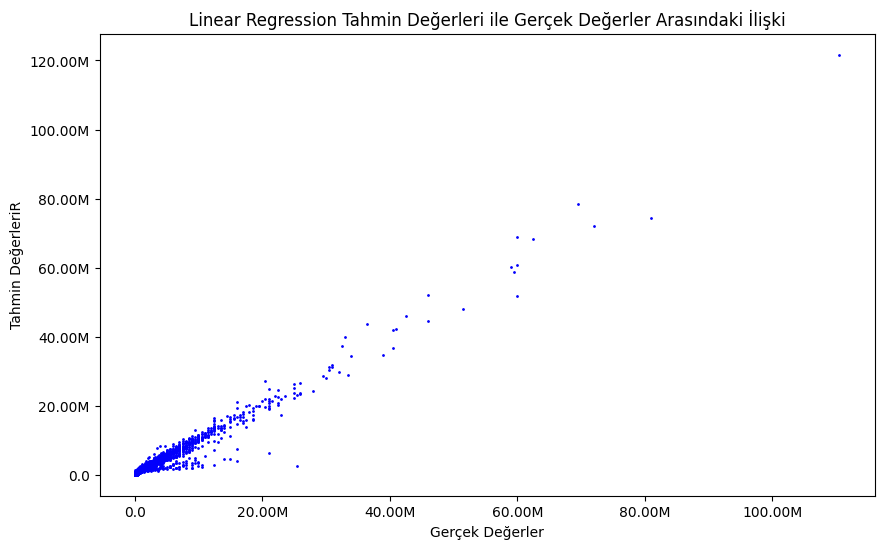

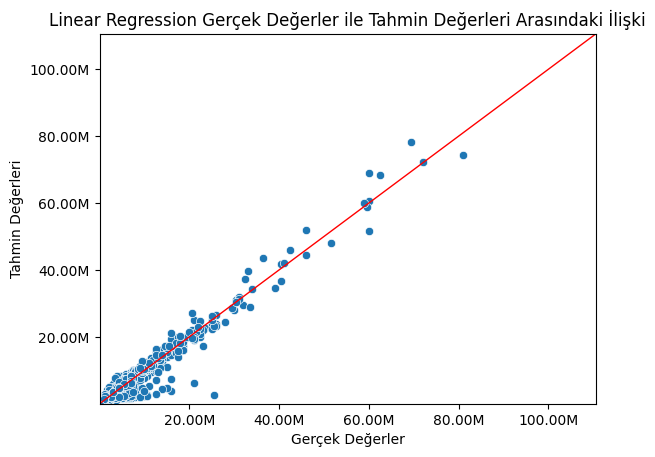

{'Linear Regression Preds': array([ -294783.07125695,  3181071.40477444,   863946.39533676, ...,
       36787775.06311745, 10672117.06368819, 17243242.33418057]), 'Linear Regression Train Score': 0.9506626443869035, 'Linear Regression Test Score': 0.9616587205498666, 'Linear Regression Calculated Scores': 0.9616587205498666, 'Linear Regression Stats DF':             PREDICT        TEST     REMAINDER  REMAINDER_ABS
5132  -2.947831e+05     90000.0 -3.847831e+05   3.847831e+05
859    3.181071e+06   4200000.0 -1.018929e+06   1.018929e+06
10434  8.639464e+05    650000.0  2.139464e+05   2.139464e+05
15251  1.261809e+06    950000.0  3.118087e+05   3.118087e+05
654    6.815425e+06   6500000.0  3.154247e+05   3.154247e+05
...             ...         ...           ...            ...
5661  -2.609983e+05    120000.0 -3.809983e+05   3.809983e+05
16454  4.858303e+06   4400000.0  4.583034e+05   4.583034e+05
38     3.678778e+07  40500000.0 -3.712225e+06   3.712225e+06
17004  1.067212e+07   9000000.0  

In [140]:

reg_main = LinearRegression().fit(X=X_train, y=y_train)
reg_main_coef = reg_main.coef_
reg_main_intercept = reg_main.intercept_
reg_main_preds = reg_main.predict(X_test)
reg_main_pred_abs = abs(reg_main_preds)
reg_main_train_score = reg_main.score(X_train, y_train)
reg_main_test_score = reg_main.score(X_test, y_test)
    
reg_stats_df = pd.DataFrame({'PREDICT' : reg_main_preds, 'TEST' : y_test})
reg_stats_df['REMAINDER'] = reg_stats_df.apply(lambda x: x.PREDICT - x.TEST, axis=1)
reg_stats_df['REMAINDER_ABS'] = abs(reg_stats_df['REMAINDER'])
    
best_knn_score_train = reg_main.score(X_train, y_train)
best_knn_score_test = reg_main.score(X_test, y_test)
    
mse = mean_squared_error(y_test, reg_main_preds)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test, reg_main_preds)
cross_val = cross_val_score(reg_main, X_train, y_train, cv=10)
r2 = r2_score(y_test, reg_main_preds)
    
lr_values = {'Linear Regression Preds'              : reg_main_preds,
             'Linear Regression Train Score'        : reg_main_train_score,
             'Linear Regression Test Score'         : reg_main_test_score,
             'Linear Regression Calculated Scores'  : r2,
             'Linear Regression Stats DF'           : reg_stats_df}
    
plt.figure(figsize=(10,6))
plt.plot(y_test,reg_main_pred_abs,'ro',color='blue', markerfacecolor='red',markersize='1')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(shorten_number))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(shorten_number))
plt.title("Linear Regression Tahmin Değerleri ile Gerçek Değerler Arasındaki İlişki")
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahmin DeğerleriR")
plt.show()   
    
Y_max = y_test.max()
Y_min = y_test.min()
import seaborn as sns
import numpy as np
plt.title("Linear Regression Gerçek Değerler ile Tahmin Değerleri Arasındaki İlişki")
ax = sns.scatterplot(x=y_test, y=reg_main_preds)
ax.set(ylim=(Y_min, Y_max))
ax.set(xlim=(Y_min, Y_max))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(shorten_number))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(shorten_number))
ax.set_xlabel("Gerçek Değerler")
ax.set_ylabel("Tahmin Değerleri")
    
X_ref = Y_ref = np.linspace(Y_min, Y_max, 100)
plt.plot(X_ref, Y_ref, color='red', linewidth=1)
plt.show()

print(lr_values)